In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# train set / data
x_train = x_train.astype('float32') / 255
# train set / target
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

# validation set / data
x_test = x_test.astype('float32') / 255
# validation set / target
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [2]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                             include_top = False,
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax')(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)

Metal device set to: Apple M1 Pro


2023-01-26 12:45:12.578499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-26 12:45:12.578911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
func_model.compile(
    loss      = tf.keras.losses.CategoricalCrossentropy(),
    metrics   = tf.keras.metrics.CategoricalAccuracy(),
    optimizer = tf.keras.optimizers.Adam())
# fit
func_model.fit(x_train, y_train, batch_size=128, epochs=15, verbose = 2)

Epoch 1/15


2023-01-26 12:45:26.842582: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-26 12:45:28.985300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 - 46s - loss: 1.3125 - categorical_accuracy: 0.5428 - 46s/epoch - 116ms/step
Epoch 2/15
391/391 - 37s - loss: 0.8097 - categorical_accuracy: 0.7172 - 37s/epoch - 94ms/step
Epoch 3/15
391/391 - 37s - loss: 0.6380 - categorical_accuracy: 0.7776 - 37s/epoch - 94ms/step
Epoch 4/15
391/391 - 38s - loss: 0.5261 - categorical_accuracy: 0.8198 - 38s/epoch - 96ms/step
Epoch 5/15
391/391 - 39s - loss: 0.4529 - categorical_accuracy: 0.8411 - 39s/epoch - 99ms/step
Epoch 6/15
391/391 - 39s - loss: 0.3898 - categorical_accuracy: 0.8641 - 39s/epoch - 100ms/step
Epoch 7/15
391/391 - 38s - loss: 0.3296 - categorical_accuracy: 0.8852 - 38s/epoch - 96ms/step
Epoch 8/15
391/391 - 36s - loss: 0.2849 - categorical_accuracy: 0.8998 - 36s/epoch - 93ms/step
Epoch 9/15
391/391 - 36s - loss: 0.2482 - categorical_accuracy: 0.9128 - 36s/epoch - 93ms/step
Epoch 10/15
391/391 - 36s - loss: 0.2257 - categorical_accuracy: 0.9217 - 36s/epoch - 91ms/step
Epoch 11/15
391/391 - 36s - loss: 0.2015 - categorical_acc

In [4]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)



In [5]:
for idx in range(len(func_model.layers)):
    print(func_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer

input_1
rescaling
normalization
tf.math.truediv
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

1/1 [==============================] - 0s 30ms/step
[[0.3989152  0.02327448 0.25274965 0.02814561 0.00817212 0.00574093
  0.00732993 0.05092196 0.18538769 0.03936248]]


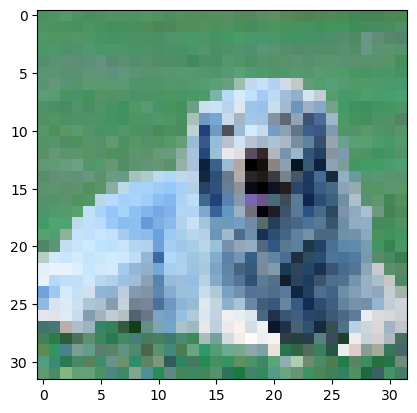

In [9]:
from matplotlib import pyplot as plt
image = cv2.imread('/Users/cabiria/Library/CloudStorage/OneDrive-SanroHealth/Desktop/sanrohealth/notebook/mnist/images/dog.jpg')
image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255
plt.imshow(image)

image = np.expand_dims(image, axis=0)

preds = func_model.predict(image)
print(preds)
i = np.argmax(preds[0])

In [45]:
icam = GradCAM(func_model, i, 'block5c_project_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

image = cv2.imread('/Users/cabiria/Library/CloudStorage/OneDrive-SanroHealth/Desktop/sanrohealth/notebook/mnist/images/dog.jpg')
image = cv2.resize(image, (32, 32))
print(heatmap.shape, image.shape)
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(32, 32) (32, 32, 3)


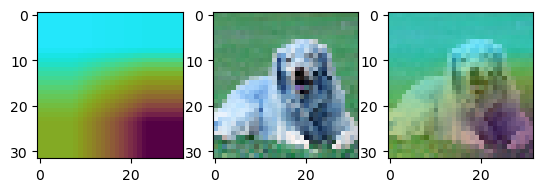

In [46]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)